# Soft Actor Critic

In [1]:
!pip install gymnasium
!pip install torch
!pip install tqdm
!pip install matplotlib
!pip install omegaconf

     ---------------------------------------- 0.0/79.5 kB ? eta -:--:--
     ---------------------------------------- 79.5/79.5 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/117.0 kB ? eta -:--:--
     ---------------------------------------- 117.0/117.0 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144578 sha256=db6635fd7a1895c47fc0deb0b0a4b359952314b5d02bec396cb82cdaf5cdf0b0
  Stored in directory: c:\users\bdk\appdata\local\pip\cache\wheels\b1\a3\c2\6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime


In [4]:
!pip install moviepy

     ---------------------------------------- 0.0/388.3 kB ? eta -:--:--
     ------------------------------------- 388.3/388.3 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/62.6 kB ? eta -:--:--
     ---------------------------------------- 62.6/62.6 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/313.2 kB ? eta -:--:--
     -------------------------------------- 313.2/313.2 kB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/22.6 MB ? eta -:--:--
      --------------------------------------- 0.5/22.6 MB 16.2 MB/s eta 0:00:02
     -- ------------------------------------- 1.3/22.6 MB 16.1 MB/s eta 0:00:02
     --- ------------------------------------ 1.9/22.6 MB 15.4 MB/s eta 0:00:02
     ---- ----------------------------------- 2.8/22.6 MB 16.2 MB/s eta 0:00:02
     ------ --------------------------------- 3.

In [11]:
!pip install gymnasium[classic-control]

     ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
     -- ------------------------------------- 0.6/10.4 MB 11.8 MB/s eta 0:00:01
     --- ------------------------------------ 0.9/10.4 MB 9.2 MB/s eta 0:00:02
     ------ --------------------------------- 1.8/10.4 MB 12.6 MB/s eta 0:00:01
     --------- ------------------------------ 2.5/10.4 MB 13.5 MB/s eta 0:00:01
     ----------- ---------------------------- 3.1/10.4 MB 13.2 MB/s eta 0:00:01
     --------------- ------------------------ 4.0/10.4 MB 14.1 MB/s eta 0:00:01
     ----------------- ---------------------- 4.5/10.4 MB 14.4 MB/s eta 0:00:01
     --------------------- ------------------ 5.6/10.4 MB 15.5 MB/s eta 0:00:01
     ---------------------- ----------------- 6.0/10.4 MB 14.7 MB/s eta 0:00:01
     ------------------------- -------------- 6.7/10.4 MB 14.9 MB/s eta 0:00:01
     ----------------------------- ---------- 7.6/10.4 MB 14.7 MB/s eta 0:00:01
     --------------------------------- ------ 8.8

In [1]:
import copy
import random
import collections

import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim


from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from gymnasium.experimental.wrappers import RecordVideoV0 as RecordVideo


# Environment

In [2]:
# continuous environment
env = gym.make('Pendulum-v1', render_mode="rgb_array")
env = RecordVideo(env, "./videos", disable_logger=True)
env

C:\anaconda3\envs\rllab\lib\site-packages\gymnasium\experimental\wrappers\rendering.py:169: UserWarning: WARN: Overwriting existing videos at C:\Users\BDK\OneDrive\Desktop\강화학습\Lab12\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


<RecordVideoV0<TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>>

# Hyperparameters

In [3]:
config = OmegaConf.create({
    # replay memory
    'buffer_limit': int(1e5),
    'batch_size': 64,
    
    # neural network parameters
    'device': 'cuda',
    'hidden_dim': 128,
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.shape[0]), # cannot use .n because not actions are continuous!
    
    # learning parameters
    'gamma': 0.98,
    'target_entropy': -1.0,
    'tau': 0.01,
    'init_alpha': 0.01,
    'lr_pi': 0.001,
    'lr_q': 0.001,
    'lr_alpha': 0.001,
})

# Replay Buffer

In [4]:
class ReplayBuffer():
    def __init__(self, config):
        self.buffer = collections.deque(maxlen=config.buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, next_s, done = transition
            s_lst.append(s.tolist())
            a_lst.append(a.tolist())
            r_lst.append([r])
            s_prime_lst.append(next_s.tolist())
            done_mask = 0.0 if done else 1.0 
            done_mask_lst.append([done_mask])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)
    
    def size(self):
        return len(self.buffer)

# Main Structure: Policy network, Q Network


In [5]:
class PolicyNet(nn.Module):
    def __init__(self, config):
        super(PolicyNet, self).__init__()
        self.config = config
        self.fc1 = nn.Linear(config.state_dim, config.hidden_dim)
        self.fc_mu = nn.Linear(config.hidden_dim,config.action_dim)
        self.fc_std  = nn.Linear(config.hidden_dim,config.action_dim)
        self.optimizer = optim.Adam(self.parameters(), lr=config.lr_pi)

        self.log_alpha = torch.tensor(np.log(config.init_alpha))
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=config.lr_alpha)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action)
        real_action = torch.tanh(action)
        real_log_prob = log_prob - torch.log(1-torch.tanh(action).pow(2) + 1e-7)
        return real_action, real_log_prob

    def train_net(self, q1, q2, mini_batch):
        s, _, _, _, _ = mini_batch
        a, log_prob = self.forward(s)
        entropy = -self.log_alpha.exp() * log_prob

        q1_val, q2_val = q1(s,a), q2(s,a)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]

        loss = -min_q - entropy # for gradient ascent
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + self.config.target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()
        
        
class QNet(nn.Module):
    def __init__(self, config):
        super(QNet, self).__init__()
        self.config = config
        self.fc_s = nn.Linear(config.state_dim, config.hidden_dim)
        self.fc_a = nn.Linear(config.action_dim,config.hidden_dim)
        self.fc_cat = nn.Linear(config.hidden_dim*2,config.hidden_dim)
        self.fc_out = nn.Linear(config.hidden_dim,1)
        self.optimizer = optim.Adam(self.parameters(), lr=config.lr_q)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_cat(cat))
        q = self.fc_out(q)
        return q

    def train_net(self, target, mini_batch):
        s, a, r, s_prime, done = mini_batch
        value = self.forward(s, a)
        # print(f"value_shape: {value.shape}")
        
        loss = F.smooth_l1_loss(value, target)
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

    def soft_update(self, net_target):
        for param_target, param in zip(net_target.parameters(), self.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.config.tau) + param.data * self.config.tau)

In [6]:
def calc_target(pi, q1, q2, mini_batch):
    s, a, r, s_prime, done = mini_batch

    with torch.no_grad():
        a_prime, log_prob= pi(s_prime)
        entropy = -pi.log_alpha.exp() * log_prob
        q1_val, q2_val = q1(s_prime,a_prime), q2(s_prime,a_prime)
        # print(f"q1_val shape: {q1_val.shape}")
        # print(f"q2_val shape: {q2_val.shape}")
        
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]
        target = r + config.gamma * done * (min_q + entropy.mean())
        # print(f"target_shape: {target.shape}")
    return target

# Learn

In [7]:
num_epis, epi_rews = 1000, []
memory = ReplayBuffer(config)
q1, q2, q1_target, q2_target = QNet(config), QNet(config), QNet(config), QNet(config)
pi = PolicyNet(config)
q1_target.load_state_dict(q1.state_dict())
q2_target.load_state_dict(q2.state_dict())
for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0
    
    while not (terminated or truncated):
        action, log_prob= pi(torch.from_numpy(state).float())

        next_state, reward, terminated, truncated, _ = env.step(action.detach().numpy())

        # save transition to replay buffer
        done = terminated or truncated
        memory.put((state, action, reward, next_state, done))
        # state transition
        state = next_state

        # record reward
        epi_rew += reward
        
        # if done:
            # print(f"n_epi total_reward: {epi_rew}")
            
    # enough memory
    if memory.size()>1000:
        for i in range(20):
            mini_batch = memory.sample(config.batch_size)
            td_target = calc_target(pi, q1_target, q2_target, mini_batch)
            q1.train_net(td_target, mini_batch)
            q2.train_net(td_target, mini_batch)
            entropy = pi.train_net(q1, q2, mini_batch)
            q1.soft_update(q1_target)
            q2.soft_update(q2_target)
            
    epi_rews += [epi_rew]
env.close()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:40<00:00,  2.17it/s]


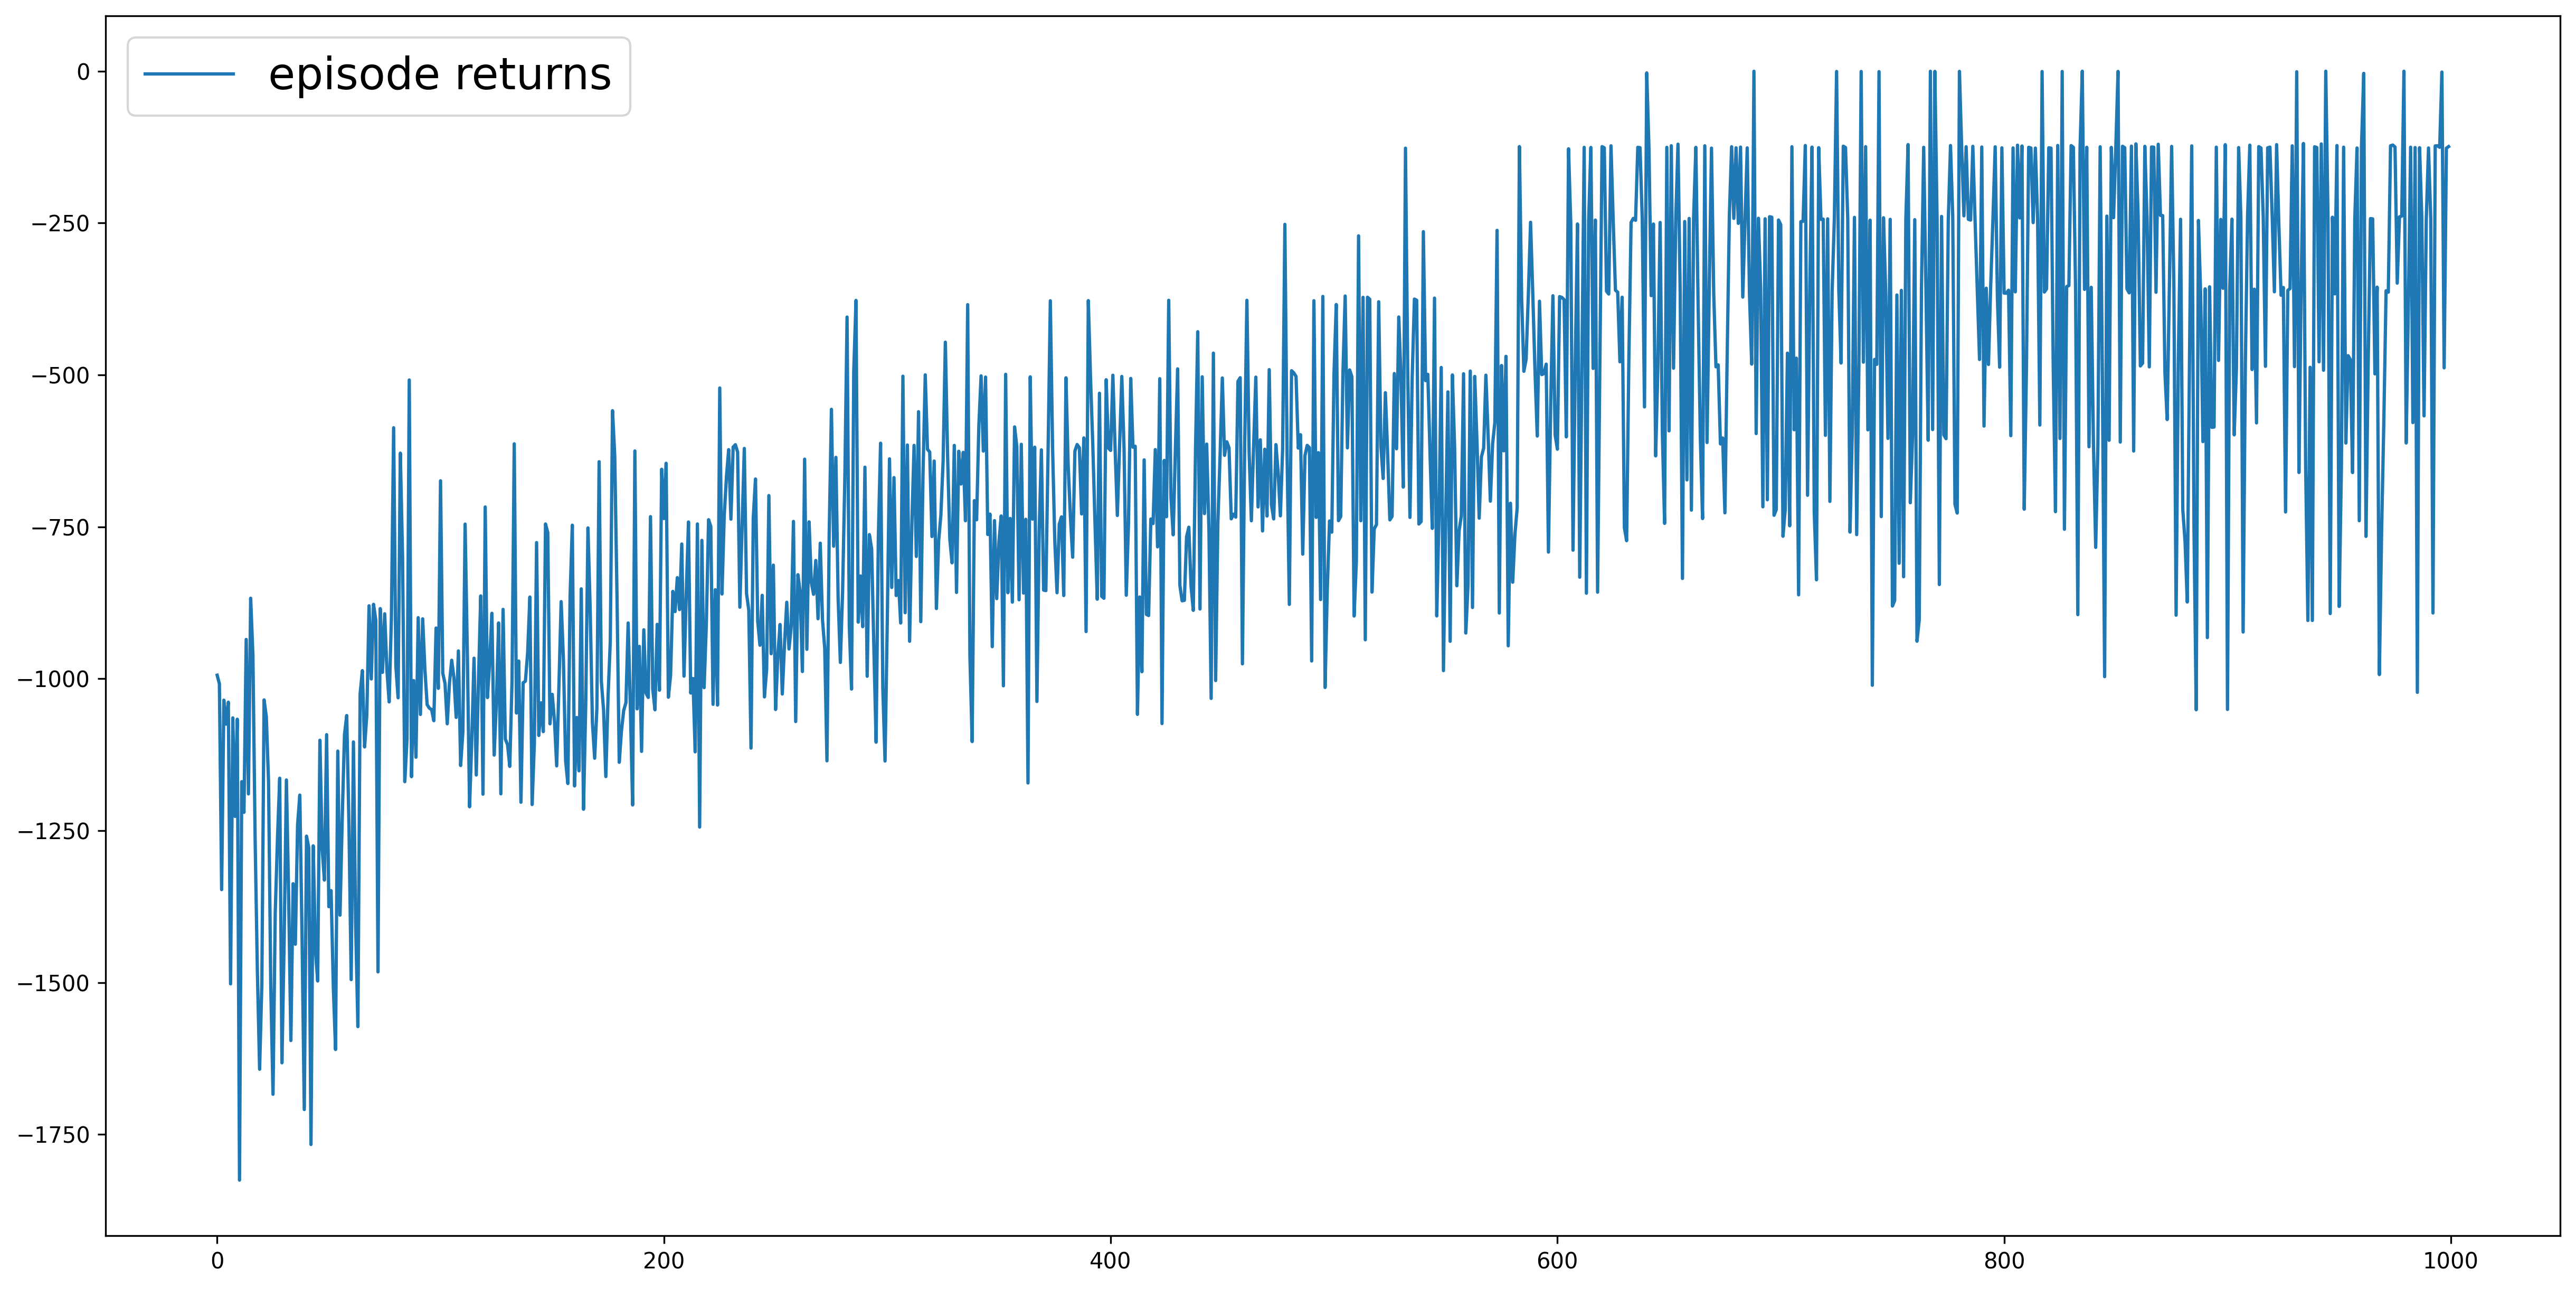

In [8]:
plt.figure(figsize=(20, 10), dpi=300)
plt.plot(epi_rews, label='episode returns')
plt.legend(fontsize=20)
plt.show()
plt.close()

# Check the video!